In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resultats-ligue-1-update/ligue1_results_update.csv
/kaggle/input/resultats-ligue-1/ligue1_results.csv


In [2]:
df = pd.read_csv("/kaggle/input/resultats-ligue-1-update/ligue1_results_update.csv")
df.head()

,Equipe,Annee,Classement_J16,Points_J16,Forme_6L,Forme_D_6L,Forme_E_6L,Buts_Pour,Buts_Contre,Coupe_Europe,Coupe_France,Final_Rank,Final_Points
0,Paris-Saint-Germain,2024,1,40,GGNNGG,GGGGNG,NNGGNG,44,14,1,1,NaN,NaN
1,Monaco,2024,3,30,GGDGND,GNDGGD,GGDGDN,26,16,1,1,NaN,NaN
2,Marseille,2024,2,30,GDGGGN,GNDDGN,GDGGGG,32,18,0,1,NaN,NaN
3,Lille,2024,4,28,NGNGNN,NGNGGN,GNGNNN,26,16,1,1,NaN,NaN
4,Lyon,2024,5,28,GNGGDG,DGNGGG,GGNNGD,28,20,1,1,NaN,NaN


In [3]:
df_pred = df[:17]
df_train = df[18:]
df_train = df_train.copy()
df_train.head()

,Equipe,Annee,Classement_J16,Points_J16,Forme_6L,Forme_D_6L,Forme_E_6L,Buts_Pour,Buts_Contre,Coupe_Europe,Coupe_France,Final_Rank,Final_Points
18,Paris-Saint-Germain,2023,1,40,GGGGNG,DGGGGG,NGGGGN,42,14,1,1,1.0,76.0
19,Monaco,2023,3,33,NDGGDG,DGGGGD,NGDNDG,33,22,0,1,2.0,67.0
20,Marseille,2023,6,27,NGGGGN,NGNGGG,DDDDNG,25,18,1,1,8.0,50.0
21,Lille,2023,5,28,NGGNND,DGGNGN,NGNNGN,21,14,1,1,4.0,59.0
22,Lyon,2023,14,16,DDDGGG,NNDNDG,DDGDDG,16,27,0,1,6.0,53.0


### Modification des features de forme

In [4]:
def str_to_pts(forme):
    res = 0
    for char in forme:
        if char == 'G':
            res += 3
        elif char == 'N':
            res += 1
    return res


df_train['Points_6L'] = df_train['Forme_6L'].apply(lambda s: str_to_pts(s))
df_train['Points_6L_D'] = df_train['Forme_D_6L'].apply(lambda s: str_to_pts(s))
df_train['Points_6L_E'] = df_train['Forme_E_6L'].apply(lambda s: str_to_pts(s))

df_train['Diff_Buts'] = df_train['Buts_Pour'] - df_train['Buts_Contre']

In [5]:
df_train.head()

,Equipe,Annee,Classement_J16,Points_J16,Forme_6L,Forme_D_6L,Forme_E_6L,Buts_Pour,Buts_Contre,Coupe_Europe,Coupe_France,Final_Rank,Final_Points,Points_6L,Points_6L_D,Points_6L_E,Diff_Buts
18,Paris-Saint-Germain,2023,1,40,GGGGNG,DGGGGG,NGGGGN,42,14,1,1,1.0,76.0,16,15,14,28
19,Monaco,2023,3,33,NDGGDG,DGGGGD,NGDNDG,33,22,0,1,2.0,67.0,10,12,8,11
20,Marseille,2023,6,27,NGGGGN,NGNGGG,DDDDNG,25,18,1,1,8.0,50.0,14,14,4,7
21,Lille,2023,5,28,NGGNND,DGGNGN,NGNNGN,21,14,1,1,4.0,59.0,9,11,10,7
22,Lyon,2023,14,16,DDDGGG,NNDNDG,DDGDDG,16,27,0,1,6.0,53.0,9,6,6,-11


### Etude de corrélation des variables

<Axes: >

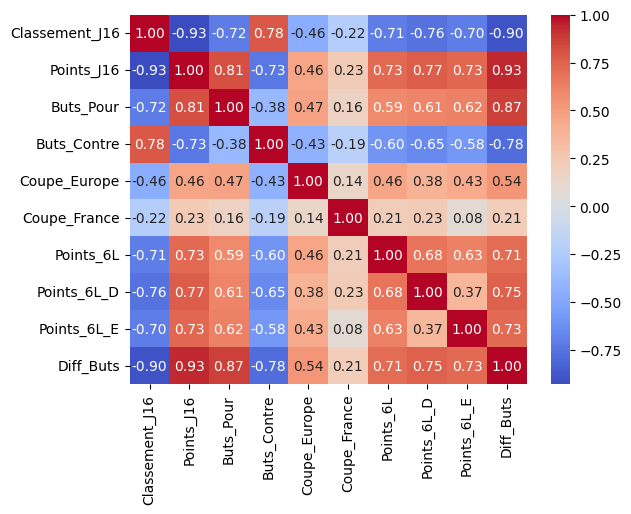

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

X = df_train[['Equipe', 'Annee', 'Classement_J16', 'Points_J16', 'Buts_Pour', 'Buts_Contre', 'Coupe_Europe', 'Coupe_France', 'Points_6L', 'Points_6L_D', 'Points_6L_E', 'Diff_Buts']]
y = df_train[['Final_Rank', 'Final_Points']]

var_corr = ['Classement_J16', 'Points_J16', 'Buts_Pour', 'Buts_Contre', 'Coupe_Europe', 'Coupe_France', 'Points_6L', 'Points_6L_D', 'Points_6L_E', 'Diff_Buts']
df_corr = df_train[var_corr]

matrix_corr = df_corr.corr()

sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', fmt=".2f")

### Représentation des évolutions

{2023: 'red', 2022: 'blue', 2021: 'green', 2020: 'magenta', 2018: 'brown', 2017: 'black', 2016: 'pink'}


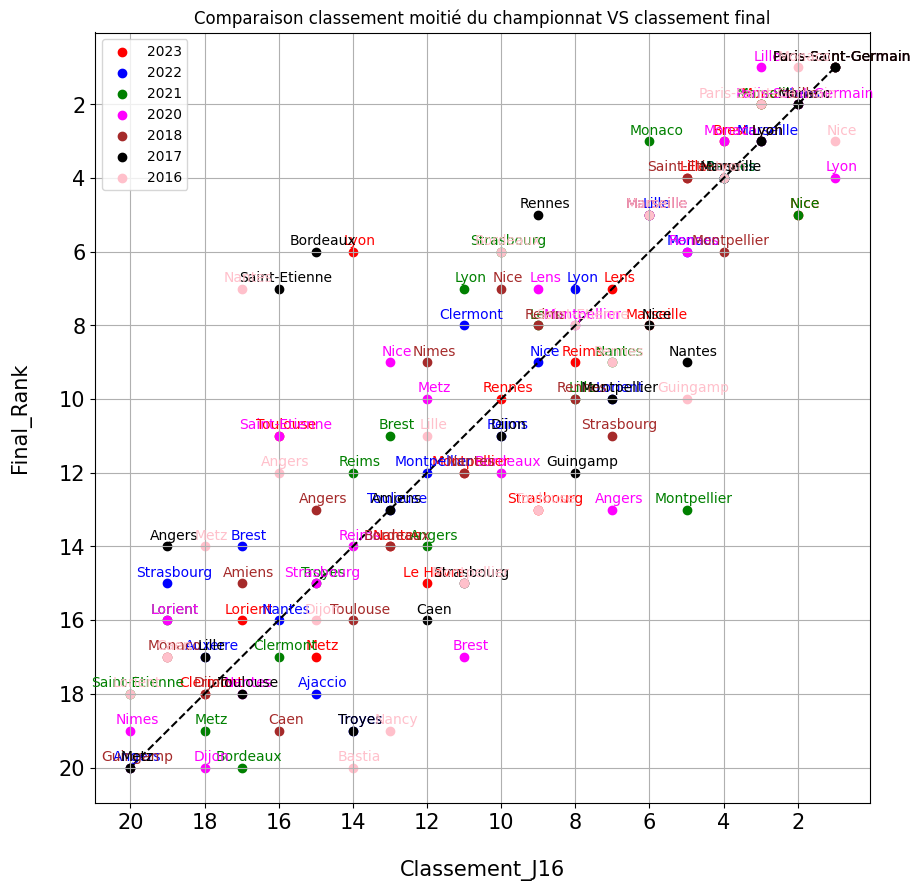

In [7]:
# Couleurs pour différencier les années
colors = ["red", "blue", "green", "magenta", "brown", "black", "pink", "purple", "yellow", "orange", "cyan"]
years = df_train['Annee'].unique()

dict_colors = dict(zip(years, colors))
print(dict_colors)

ticks = np.arange(0, 22, 2)

plt.figure(figsize=(10, 10))

for annee in years:
    df_annee = df_train[df_train['Annee'] == annee]

    plt.scatter(df_annee['Classement_J16'], df_annee['Final_Rank'], color=dict_colors[annee], label=str(annee))
    plt.xlabel('{}'.format('Classement_J16'), size=15, labelpad=20)
    plt.ylabel('{}'.format('Final_Rank'), size=15, labelpad=20)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.xticks(ticks=ticks)
    plt.yticks(ticks=ticks)

for i, row in df_train.iterrows():
    plt.annotate(
        "{}".format(row['Equipe']),  # Texte de l'annotation
        (row['Classement_J16'], row['Final_Rank']),  # Coordonnées du point
        textcoords="offset points",  # Décalage relatif au point
        xytext=(5, 5),  # Décalage en pixels (x, y)
        ha="center",  # Alignement horizontal
        fontsize=10,
        color=dict_colors[row['Annee']]
    )

# Inverser l'axe X (mettre 0 à droite)
plt.gca().invert_xaxis()

# Inverser l'axe Y (mettre 0 en haut)
plt.gca().invert_yaxis()

plt.plot(np.arange(1,21,1), np.arange(1,21,1), color='black', linestyle='--')
plt.title('Comparaison classement moitié du championnat VS classement final')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()